In [12]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.signal import chirp, spectrogram, butter, filtfilt
from scipy.stats import linregress

In [13]:
# Parameters
fs = 4400e6 # ADC Sampling frequency (Hz)
T = 72e-6  # Chirp duration (seconds)
t = np.linspace(0, T, int(fs*T))  # Time vector

# Chirp parameters
# f0 = 500  # Starting frequency (Hz)
# B1 = 4000  # Bandwidth of first chirp (Hz)
# B2 = 6000  # Bandwidth of second chirp (Hz)

f0 = 77e9
B1 = 4e9  
B2 = 3.8e9

# Generate two chirps with different slopes
chirp1 = chirp(t, f0=f0, f1=f0 + B1, t1=T, method='linear')
chirp2 = chirp(t, f0=f0, f1=f0 + B2, t1=T, method='linear')


# # Plot chirps
# plt.figure(figsize=(10, 6))
# plt.subplot(2, 1, 1)
# plt.plot(t, chirp1, label="Chirp 1 (Slope 1)")
# plt.title("Chirp 1")
# plt.xlabel("Time (s)")
# plt.ylabel("Amplitude")
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(t, chirp2, label="Chirp 2 (Slope 2)", color='orange')
# plt.title("Chirp 2")
# plt.xlabel("Time (s)")
# plt.ylabel("Amplitude")
# plt.legend()

# plt.tight_layout()
# plt.show()


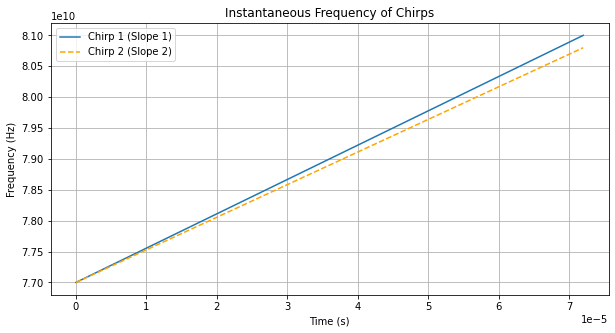

In [14]:
# Compute instantaneous frequency (slope of phase derivative)
freq1 = f0 + (B1/T) * t  # Linear chirp equation
freq2 = f0 + (B2/T) * t  # Linear chirp equation

# Plot frequency vs. time
plt.figure(figsize=(10, 5))
plt.plot(t, freq1, label="Chirp 1 (Slope 1)")
plt.plot(t, freq2, label="Chirp 2 (Slope 2)", linestyle='dashed', color='orange')
plt.title("Instantaneous Frequency of Chirps")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.legend()
plt.grid()
plt.show()

In [15]:
if_signal = chirp1*chirp2

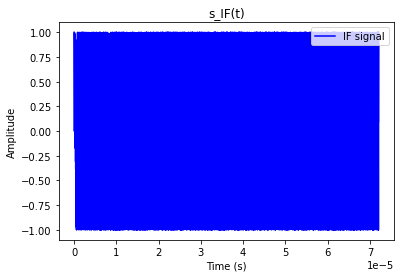

In [16]:
plt.plot(t, if_signal, label="IF signal", color='blue')
plt.title("s_IF(t)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

In [17]:
# Design a low-pass filter (LPF)
cutoff_freq = 0.25e9  # Cutoff frequency (Hz), adjust as needed
order = 4  # Filter order
nyquist = fs / 2  # Nyquist frequency

print(cutoff_freq / nyquist)

# Create Butterworth LPF
b, a = butter(order, Wn = cutoff_freq / nyquist, btype='low')

# Apply the filter
if_signal_lpf = filtfilt(b, a, if_signal)

0.11363636363636363


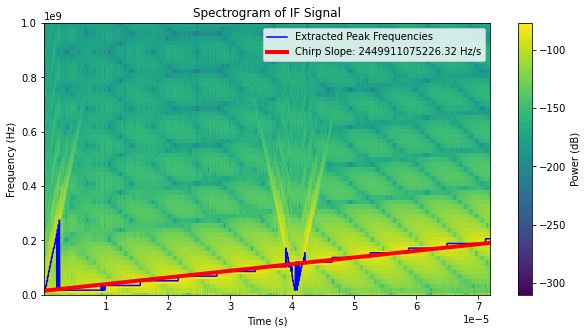

In [18]:
# Compute spectrogram (STFT)
# f, t_spec, Sxx = spectrogram(if_signal, fs) #, nperseg=256)
f, t_spec, Sxx = spectrogram(if_signal_lpf, fs)

# Convert to dB scale for better visualization
Sxx_dB = 10 * np.log10(Sxx + 1e-10)  # Avoid log(0)

# Extract peak frequency at each time step
peak_freqs = f[np.argmax(Sxx, axis=0)]

# Fit a linear regression model to estimate the chirp slope
slope, intercept, _, _, _ = linregress(t_spec, peak_freqs)

# Plot spectrogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='auto')
plt.plot(t_spec, peak_freqs, 'b', label="Extracted Peak Frequencies")
plt.plot(t_spec, slope * t_spec + intercept, c='r', lw=4, label=f"Chirp Slope: {slope:.2f} Hz/s")
plt.colorbar(label='Power (dB)')
plt.title("Spectrogram of IF Signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
# plt.ylim([0, fs/2])  # Display up to Nyquist frequency
plt.ylim([0, 1e9])
plt.legend()
plt.show() 

In [19]:
S1 = B1/T
S2 = B2/T

S1 - S2

2777777777777.7812

In [20]:
error = ((S1-S2) - slope)/(S1-S2) * 100 
error

11.803201291852702

# W/O Sync

In [51]:
tau = 0.2*T
t_wo_sync = np.linspace(0, T-tau, int(fs*(T-tau)))
B2_wo_sync = B2*(T-tau)/T

# Generate the other chirp shifted by tau
chirp2_wo_sync = chirp(t, f0=f0, f1=f0 + B2, t1=T, phi=360*(tau/T), method='linear')
# chirp2_wo_sync = np.zeros(int(fs*T))
# chirp2_wo_sync[:int(fs*tau)] = chirp(t, f0=f0, f1=f0 + B2, t1=T, method='linear')[:int(fs*tau)]
# chirp2_wo_sync[int(fs*tau):] = chirp(t_wo_sync, f0=f0, f1=f0 + B2_wo_sync, t1=T, method='linear')

No handles with labels found to put in legend.


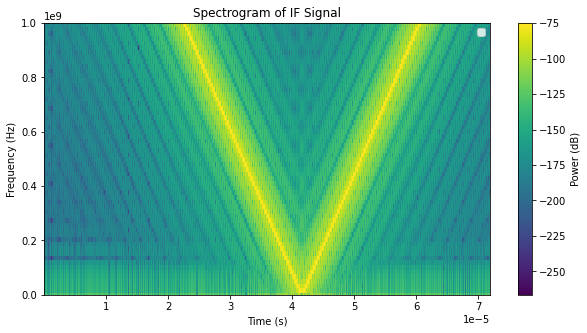

In [52]:
f1, t_spec1, Sxx1 = spectrogram(chirp2_wo_sync, fs)
# Plot spectrogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(t_spec1, f1, 10 * np.log10(Sxx1), shading='auto')
# plt.plot(t_spec, peak_freqs, 'b', label="Extracted Peak Frequencies")
# plt.plot(t_spec, slope * t_spec + intercept, c='r', lw=4, label=f"Chirp Slope: {slope:.2f} Hz/s")
plt.colorbar(label='Power (dB)')
plt.title("Spectrogram of IF Signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
# plt.ylim([0, fs/2])  # Display up to Nyquist frequency
plt.ylim([0, 1e9])
plt.legend()
plt.show() 

In [53]:
if_signal_wo_sync = chirp1 * chirp2_wo_sync

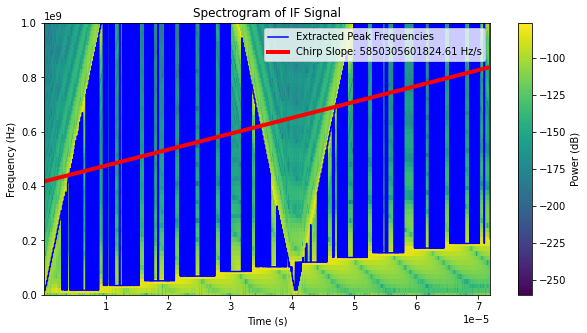

In [55]:
f2, t_spec2, Sxx2 = spectrogram(if_signal_wo_sync, fs)

# Convert to dB scale for better visualization
Sxx2_dB = 10 * np.log10(Sxx2 + 1e-10)  # Avoid log(0)

# Extract peak frequency at each time step
peak_freqs2 = f[np.argmax(Sxx2, axis=0)]

# Fit a linear regression model to estimate the chirp slope
slope2, intercept2, _, _, _ = linregress(t_spec2, peak_freqs2)

# Plot spectrogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(t_spec2, f2, 10 * np.log10(Sxx2), shading='auto')
plt.plot(t_spec2, peak_freqs2, 'b', label="Extracted Peak Frequencies")
plt.plot(t_spec2, slope2 * t_spec2 + intercept2, c='r', lw=4, label=f"Chirp Slope: {slope2:.2f} Hz/s")
plt.colorbar(label='Power (dB)')
plt.title("Spectrogram of IF Signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
# plt.ylim([0, fs/2])  # Display up to Nyquist frequency
plt.ylim([0, 1e9])
plt.legend()
plt.show() 